# Week 1: Working with time series

Welcome! In this assignment you will be working with time series data. All of the data is going to be generated and you will implement several functions to split the data, create forecasts and evaluate the quality of those forecasts.


#### TIPS FOR SUCCESSFUL GRADING OF YOUR ASSIGNMENT:

- All cells are frozen except for the ones where you need to submit your solutions or when explicitly mentioned you can interact with it.
- You can add new cells to experiment but these will be omitted by the grader, so don't rely on newly created cells to host your solution code, use the provided places for this.

- You can add the comment # grade-up-to-here in any graded cell to signal the grader that it must only evaluate up to that point. This is helpful if you want to check if you are on the right track even if you are not done with the whole assignment. Be sure to remember to delete the comment afterwards!

- Avoid using global variables unless you absolutely have to. The grader tests your code in an isolated environment without running all cells from the top. As a result, global variables may be unavailable when scoring your submission. Global variables that are meant to be used will be defined in UPPERCASE.
 
- This assignment builds one block on top of the other, so it is very important that you pass all unittests before continuing to the next section, otherwise you might have issues grading your submission.

- To submit your notebook, save it and then click on the blue submit button at the beginning of the page.

Let's get started!

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

2024-09-26 14:05:06.451805: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-26 14:05:06.459768: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-26 14:05:06.468872: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-26 14:05:06.471582: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-26 14:05:06.478483: I tensorflow/core/platform/cpu_feature_guar

In [3]:
import unittests

The next cell includes a bunch of helper functions to generate and plot the time series:

In [4]:
def trend(time, slope=0):
    """A trend over time"""
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 7 * np.pi),
                    1 / np.exp(5 * season_time))


def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)


def noise(time, noise_level=1, seed=None):
    """Adds noise to the series"""
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level


def plot_series(time, series, format="-", title="", label=None, start=0, end=None):
    """Plot the series"""
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.title(title)
    if label:
        plt.legend()
    plt.grid(True)

## Generate time series data

Using the previous functions, generate data that resembles a real-life time series.

Notice that `TIME` represents the values in the x-coordinate while `SERIES` represents the values in the y-coordinate. This naming is used to avoid confusion with other kinds of data in which `x` and `y` have different meanings.

[   0.    1.    2. ... 1458. 1459. 1460.]


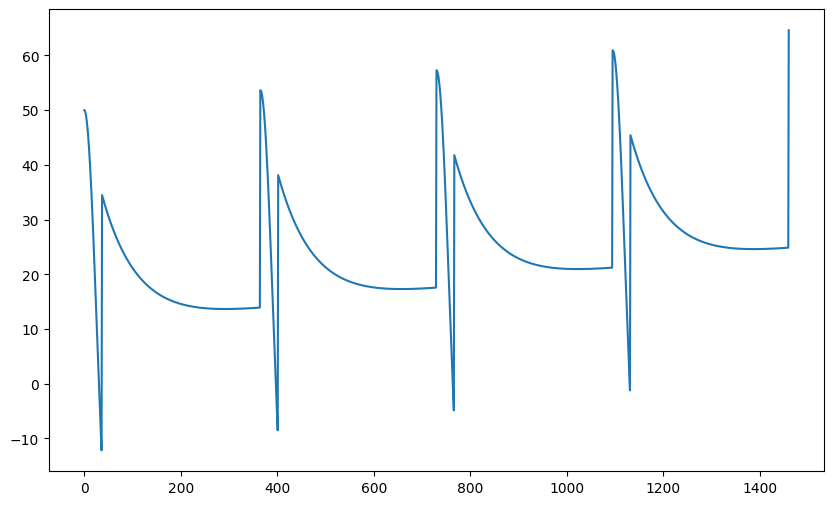

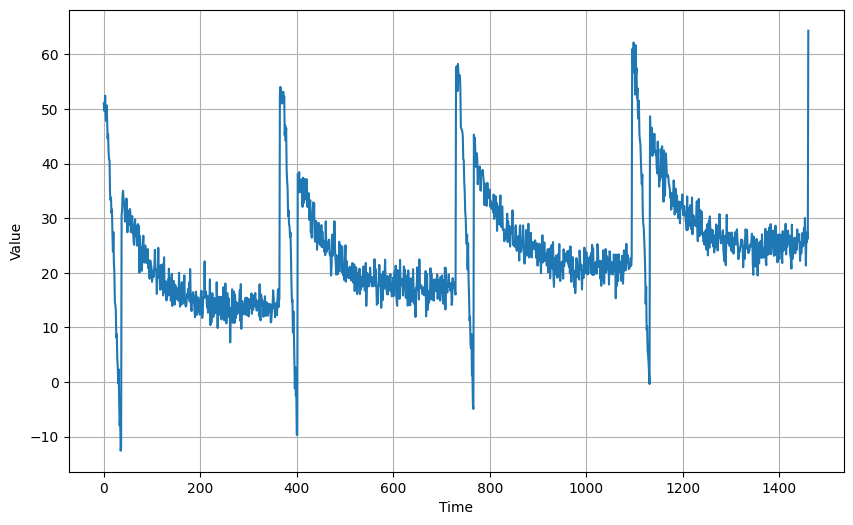

In [22]:
# The time dimension or the x-coordinate of the time series
TIME = np.arange(4 * 365 + 1, dtype="float32")

#Enabling printing of float values in more readable format
np.set_printoptions(suppress=True)
print(TIME)

# Initial series is just a straight line with a y-intercept
y_intercept = 10
slope = 0.01
SERIES = trend(TIME, slope) + y_intercept

# Adding seasonality
amplitude = 40
SERIES += seasonality(TIME, period=365, amplitude=amplitude)

plt.figure(figsize=(10, 6))
plt.plot(TIME, SERIES)

# Adding some noise
noise_level = 2
SERIES += noise(TIME, noise_level, seed=42)

# Plot the series
plt.figure(figsize=(10, 6))
plot_series(TIME, SERIES)
#NOTE: not needed in the case of Kupyter notebook
plt.show()

This is a good time to also define some useful global variables. 

In [25]:
# Define time step to split the series
SPLIT_TIME = 1100

# Define the window size for forecasting later on
WINDOW_SIZE = 50

### Exercise 1: train_val_split

Now that you have the time series, let's split it so you can start forecasting.

Complete the `train_val_split` function below which receives the `time` (x coordinate) and `series` (y coordinate) data. Notice that this value defaults to 1100 since this is an appropriate step to split the series into training and validation:

In [44]:
# GRADED FUNCTION: train_val_split
def train_val_split(time, series):
    """Split time series into train and validation sets

    Args:
        time (np.ndarray): array with timestamps
        series (np.ndarray): array with values of the time series

    Returns:
        (np.ndarray, np.ndarray, np.ndarray, np.ndarray): tuple containing timestamp and 
                                                          series values for train and validation
    """
    ### START CODE HERE ###
    # Get train split
    time_train = time[:SPLIT_TIME]
    series_train = series[:SPLIT_TIME]
    
    # Get validation split
    time_valid = time[SPLIT_TIME:]
    series_valid = series[SPLIT_TIME:]
    ### END CODE HERE ###

    return time_train, series_train, time_valid, series_valid

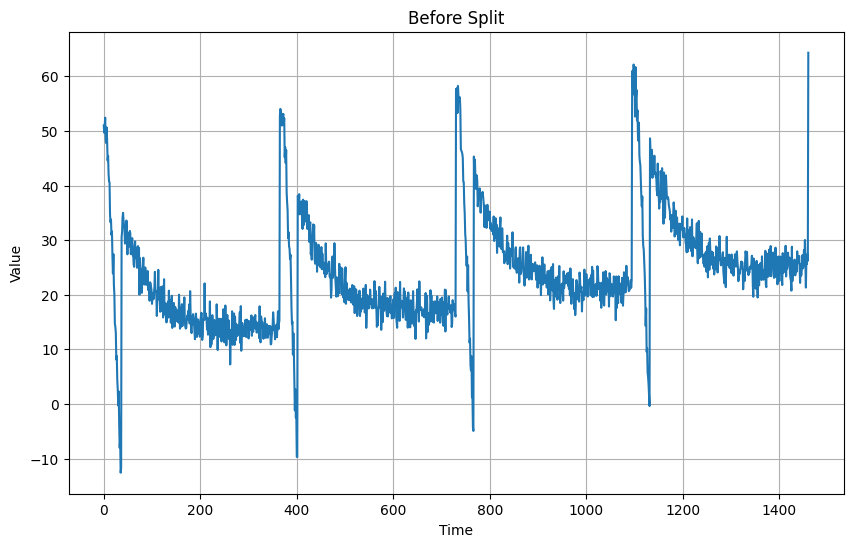

(1100,) (1100,)
(361,) (361,)


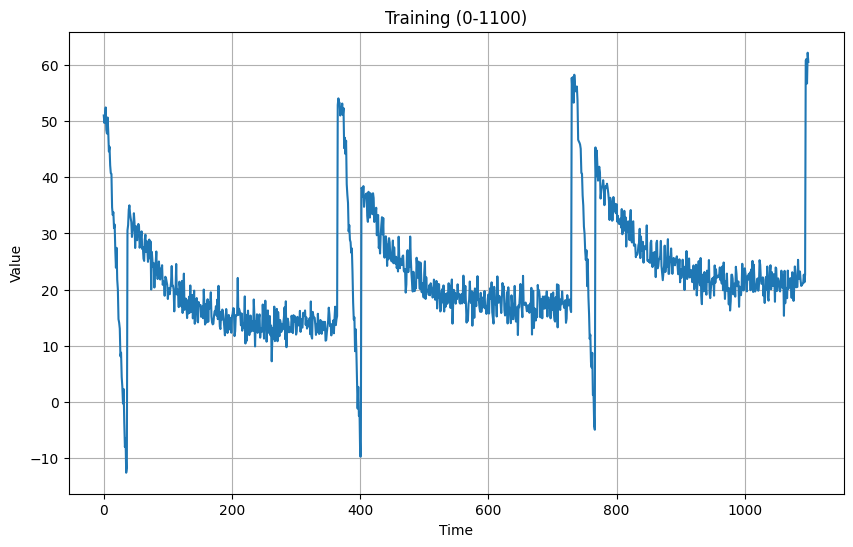

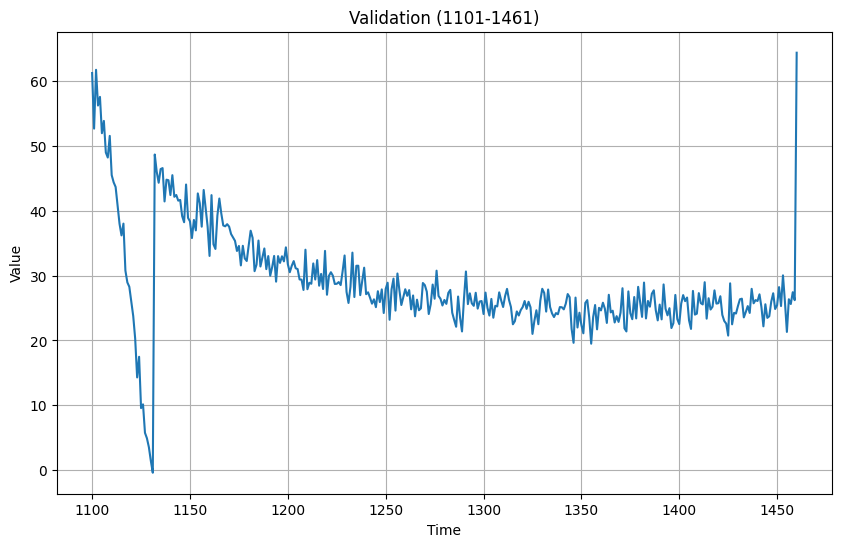

In [45]:
# Get your train and validation splits
time_train, series_train, time_valid, series_valid = train_val_split(TIME, SERIES)

plt.figure(figsize=(10, 6))
plot_series(TIME, SERIES, title="Before Split")
plt.show()

print(time_train.shape, series_train.shape)
plt.figure(figsize=(10, 6))
plot_series(time_train, series_train, title="Training (0-1100)")

print(time_valid.shape, series_valid.shape)
plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid, title="Validation (1101-1461)")

**Expected Output:**

<table><tr><td><img src='images/train_series.png' ></td><td><img src='images/val_series.png'></td></tr></table>

In [15]:
# Test your code!
unittests.test_train_val_split(train_val_split)

 All tests passed!


## Evaluation Metrics

### Exercise 2: compute_metrics

Now that you have successfully split the data into training and validation sets you will need a way of knowing how good your forecasts are. For this complete the `compute_metrics` below. This function receives the true series and the forecast and returns the `mse` and the `mae` between the two curves.  You should use functions provided by [`tf.keras.losses`](https://www.tensorflow.org/api_docs/python/tf/keras/losses) to compute MSE and MAE errors.

**Notice that this function does not receive any time (x coordinate) data since it assumes that both series will have the same values for the x coordinate**

In [31]:
# GRADED FUNCTION: compute_metrics
def compute_metrics(true_series, forecast):
    """compute mean squared error and mean absolute error for predictions

    Args:
        true_series (np.ndarray): original (true) series
        forecast (np.ndarray): forecast series

    Returns:
        (np.float64, np.float64): MSE and MAE
    """
    ### START CODE HERE ###
    mse = np.mean(np.square(true_series - forecast))  # Mean Squared Error
    mae = np.mean(np.abs(true_series - forecast))     # Mean Absolute Error
    ### END CODE HERE ###

    return mse, mae

In [33]:
# Try out your function

# Define some dummy series for testing
zeros = np.zeros(5)
ones = np.ones(5)

mse, mae = compute_metrics(zeros, ones)
print(f"mse: {mse}, mae: {mae} for series of zeros and prediction of ones\n")

mse, mae = compute_metrics(ones, ones)
print(f"mse: {mse}, mae: {mae} for series of ones and prediction of ones")

mse: 1.0, mae: 1.0 for series of zeros and prediction of ones

mse: 0.0, mae: 0.0 for series of ones and prediction of ones


**Expected Output:**

```
mse: 1.0, mae: 1.0 for series of zeros and prediction of ones

mse: 0.0, mae: 0.0 for series of ones and prediction of ones
```

In [34]:
# Test your code!
unittests.test_compute_metrics(compute_metrics)

 All tests passed!


# Forecasting

Now that you have a way of measuring the performance of your forecasts it is time to actually start doing some forecasts. Your goal is to predict the values in the validation set.

Let's start easy by using a naive forecast.

## Naive Forecast

### Exercise 3: naive_forecast

Define the `naive_forecast` variable below. Remember that the naive forecast simply takes the last value to predict the next one. This means that the forecast series should be identical to the validation series but delayed one time step. 

**Hint:**

**You need to pass the correct elements of the original series `SERIES` to compute the `naive_forecast`. Here are a few things to keep in mind:**

- To make the forecast for the first element in the validation set you need the value of the very last element on the train set
- You should leave out the last element, since the forecast obtained using this value does not exists in the validation set and you will not be able to compute the evaluation metrics if this element is kept.

In [166]:
# GRADED VARIABLE
### START CODE HERE ###
naive_forecast = SERIES[SPLIT_TIME-1:len(SERIES)-1]  # Naive forecast for the validation set
### END CODE HERE ###

In [167]:
# Look into naive_forecast
print(f"validation series has shape: {series_valid.shape}\n")
print(f"naive forecast has shape: {naive_forecast.shape}\n")
print(f"comparable with validation series: {series_valid.shape == naive_forecast.shape}")

validation series has shape: (361,)

naive forecast has shape: (361,)

comparable with validation series: True


**Expected Output:**

```
validation series has shape: (361,)

naive forecast has shape: (361,)

comparable with validation series: True
```

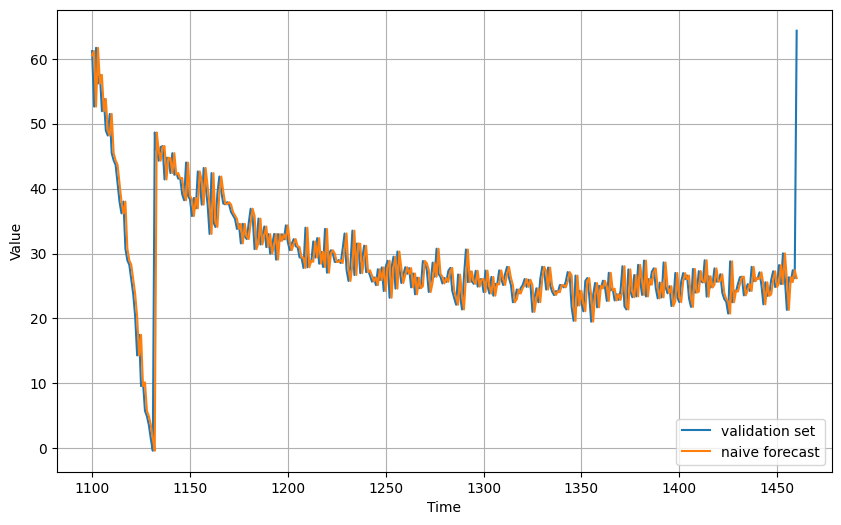

In [52]:
# Plot the validation data and the naive forecast
plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid, label="validation set")
plot_series(time_valid, naive_forecast, label="naive forecast")

**Expected Output:**

<div>
<img src="images/naive.png" width="650"/>
</div>

Let's zoom in on the end of the validation period:

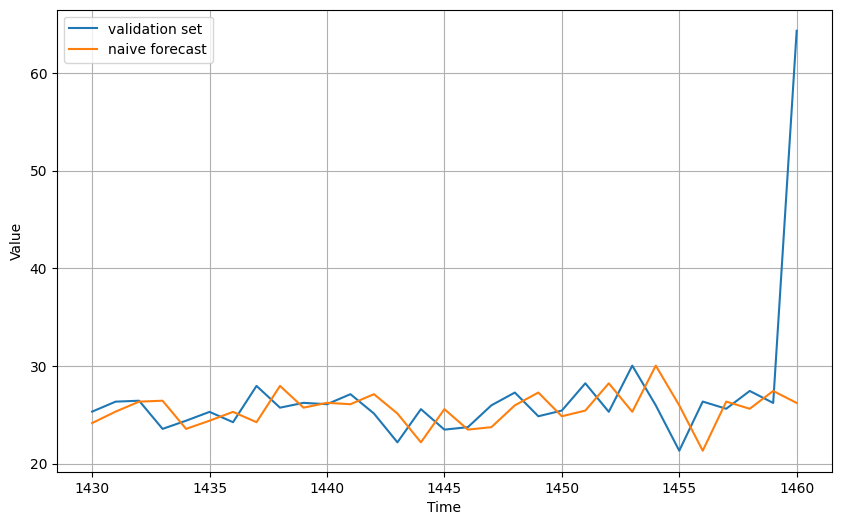

In [53]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid, start=330, end=361, label="validation set")
plot_series(time_valid, naive_forecast, start=330, end=361, label="naive forecast")

**Expected Output:**

<div>
<img src="images/naive_zoom.png" width="650"/>
</div>

**You should see that the naive forecast lags 1 step behind the time series and that both series end on the same time step.**

Now let's compute the mean squared error and the mean absolute error between the forecasts and the predictions in the validation period:

In [54]:
mse, mae = compute_metrics(series_valid, naive_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for naive forecast")

mse: 19.58, mae: 2.60 for naive forecast


**Expected Output:**

```
mse: 19.58, mae: 2.60 for naive forecast
```

In [168]:
# Test your code!
unittests.test_naive_forecast(naive_forecast)

 All tests passed!


That's our baseline, now let's try a moving average.

## Moving Average

### Exercise 4: moving_average_forecast

Complete the `moving_average_forecast` function below. This function receives a `series` and a `window_size` and computes the moving average forecast for every point after the initial `window_size` values.

**This function should receive the complete `SERIES` and, just for this exercise, you will get the prediction for all the `SERIES`. The returned prediction will then be sliced to match the validation period, so your function doesn't need to account for matching the series to the validation period.**

In [190]:
# GRADED FUNCTION: moving_average_forecast
def moving_average_forecast(series, window_size):
    """Forecasts the mean of the last few values.
        If window_size=1, then this is equivalent to naive forecast

    Args:
        series (np.ndarray): time series
        window_size (int): window size for the moving average forecast

    Returns:
        np.ndarray: time series forcast
    """
    
    forecast = []
    
    ### START CODE HERE ###
    for time in range(window_size, len(series)):
      # Average the previous `window_size` values
        forecast.append(np.mean(series[time - window_size:time]))

    # Convert to a numpy array
    np_forecast = np.array(forecast)
   
    ### END CODE HERE ###
    
    return np_forecast

You cannot compute the moving average for the first `window_size` values since there aren't enough values to compute the desired average. So if you use the whole `SERIES` and a `window_size` of 50 your function should return a series with the number of elements equal to:

```python
len(SERIES) - 50
````

In [191]:
print(f"Whole SERIES has {len(SERIES)} elements so the moving average forecast should have {len(SERIES)-50} elements")

Whole SERIES has 1461 elements so the moving average forecast should have 1411 elements


In [192]:
# Try out your function
moving_avg = moving_average_forecast(SERIES, window_size=WINDOW_SIZE)
print(f"moving average forecast with whole SERIES has shape: {moving_avg.shape}\n")

# Slice it so it matches the validation period
moving_avg = moving_avg[1100 - WINDOW_SIZE:]
print(f"moving average forecast after slicing has shape: {moving_avg.shape}\n")
print(f"comparable with validation series: {series_valid.shape == moving_avg.shape}")

moving average forecast with whole SERIES has shape: (1411,)

moving average forecast after slicing has shape: (361,)

comparable with validation series: True


**Expected Output:**

```
moving average forecast with whole SERIES has shape: (1411,)

moving average forecast after slicing has shape: (361,)

comparable with validation series: True
```

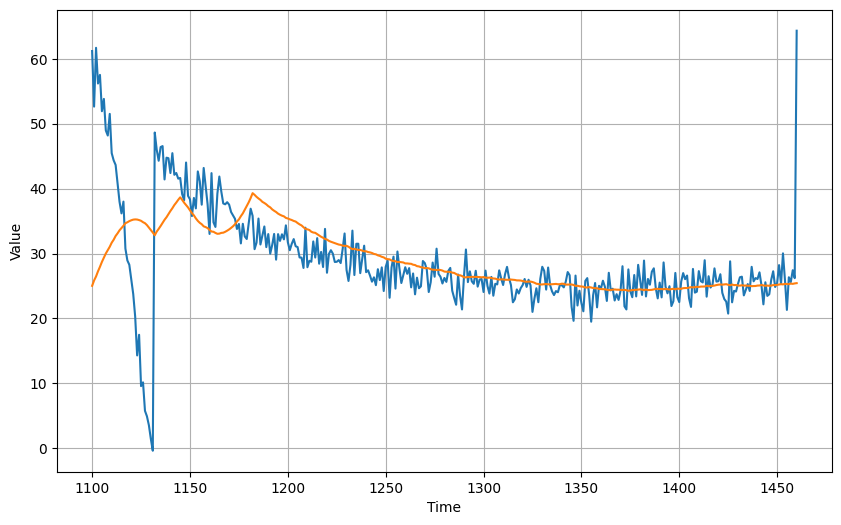

In [193]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, moving_avg)

**Expected output:**
<div>
<img src="images/moving_avg.png" width="650"/>
</div>

In [194]:
# Compute evaluation metrics
mse, mae = compute_metrics(series_valid, moving_avg)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for moving average forecast")

mse: 56.80, mae: 4.12 for moving average forecast


**Expected Output:**

```
mse: 56.80, mae: 4.12 for moving average forecast
```

In [195]:
# Test your code!
unittests.test_moving_average_forecast(moving_average_forecast)

 All tests passed!


That's worse than naive forecast! The moving average does not anticipate trend or seasonality, so let's try to remove them by using differentiation. 

## Differencing

### Exercise 5: diff_series

Since the seasonality period is 365 days, we will subtract the value at time *t* – 365 from the value at time *t*.

Define the `diff_series` and `diff_time` variables below to achieve this. Notice that `diff_time` is the values of the x-coordinate for `diff_series`.

In [196]:
# GRADED VARIABLES
### START CODE HERE ###
diff_series = SERIES[365:] - SERIES[:-365]  # Simple first-order difference (current value - previous value)

# Get the appropriate time indexes (excluding the first time step because it's used for differentiation)
diff_time = TIME[365:]

print(diff_series)
print(diff_time)
### END CODE HERE ###

[1.8541336 4.37471   2.3798103 ... 6.125614  3.531084  3.534523 ]
[ 365.  366.  367. ... 1458. 1459. 1460.]


In [197]:
print(f"Whole SERIES has {len(SERIES)} elements so the differencing should have {len(SERIES)-365} elements\n")
print(f"diff series has shape: {diff_series.shape}\n")
print(f"x-coordinate of diff series has shape: {diff_time.shape}\n")

Whole SERIES has 1461 elements so the differencing should have 1096 elements

diff series has shape: (1096,)

x-coordinate of diff series has shape: (1096,)



**Expected Output:**
```
Whole SERIES has 1461 elements so the differencing should have 1096 elements

diff series has shape: (1096,)

x-coordinate of diff series has shape: (1096,)
```

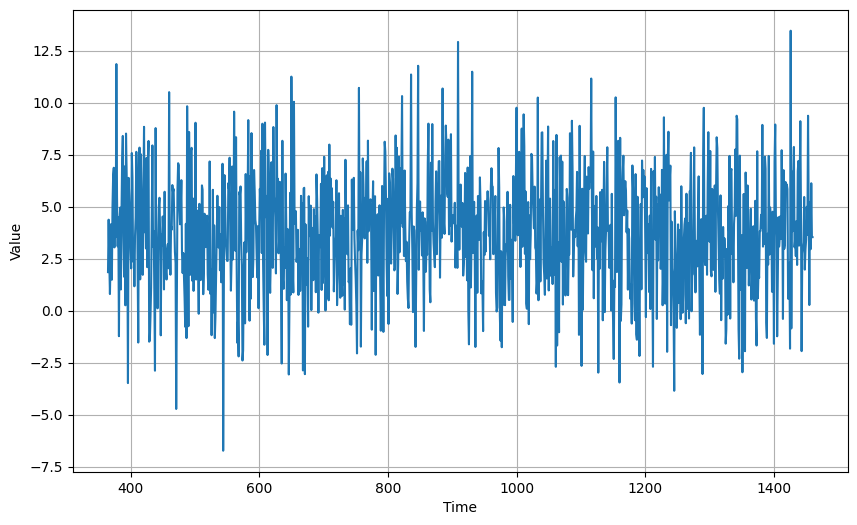

In [198]:
plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series)

**Expected output:**

<div>
<img src="images/diff.png" width="650"/>
</div>

In [199]:
# Test your code!
unittests.test_diff_series(diff_series)

 All tests passed!


### Exercise 6: diff_moving_average

Great, the trend and seasonality seem to be gone, so now we can use the moving average.

Define the `diff_moving_avg` variable. 

**Notice that the `window_size` has already being defined and that you will need to perform the correct slicing for the series to match the validation period.**

In [202]:
# GRADED VARIABLE
### START CODE HERE ###

# Apply the moving average to the differenced series. Use the correct window_size
diff_moving_avg = moving_average_forecast(diff_series, WINDOW_SIZE)
print(f"moving average forecast with diff series has shape: {diff_moving_avg.shape}\n")

# Perform the correct slicing
#Both logics shown below are same as they end of picking last 361 elements in the series
#which is same
#print(diff_moving_avg[SPLIT_TIME - 365 - WINDOW_SIZE:])
#print(diff_moving_avg[-len(series_valid):])

diff_moving_avg = diff_moving_avg[SPLIT_TIME - 365 - WINDOW_SIZE:]
### END CODE HERE ###

moving average forecast with diff series has shape: (1046,)



In [203]:
print(f"moving average forecast with diff series after slicing has shape: {diff_moving_avg.shape}\n")
print(f"comparable with validation series: {series_valid.shape == diff_moving_avg.shape}")

moving average forecast with diff series after slicing has shape: (361,)

comparable with validation series: True


**Expected Output:**
```
moving average forecast with diff series after slicing has shape: (361,)

comparable with validation series: True
```

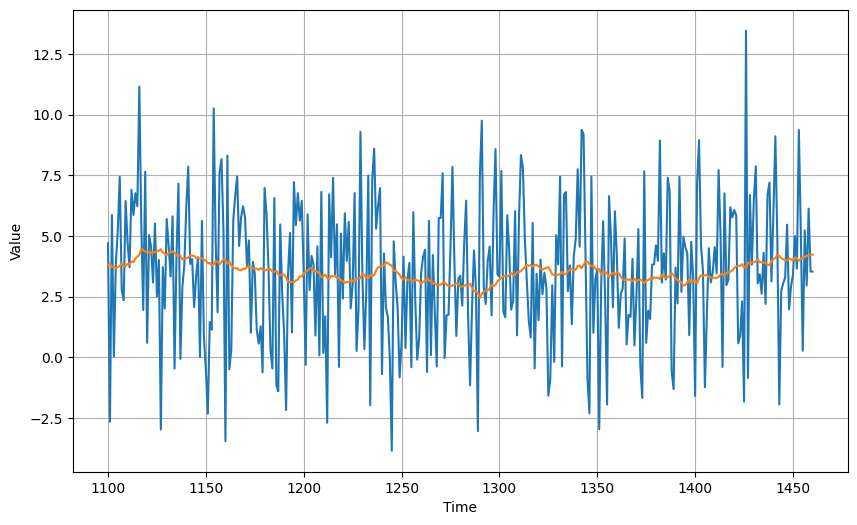

In [204]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[1100 - 365:])
plot_series(time_valid, diff_moving_avg)

**Expected output:**

<div>
<img src="images/diff_moving.png" width="650"/>
</div>

In [205]:
# Test your code!
unittests.test_diff_moving_avg(diff_moving_avg)

 All tests passed!


### Exercise 7: diff_moving_avg_plus_past

Now let's bring back the trend and seasonality by adding the past values from t – 365. For each value you want to forecast, you will be adding the exact same point, but from the previous cycle in the original time series. 

In [242]:
# GRADED VARIABLES
### START CODE HERE ###

# Slice the whole SERIES to get the past values.
past_series = SERIES[SPLIT_TIME-365:-365]

# Both logics are same
#past_series = SERIES[-(len(diff_moving_avg) + 365): -365] 
#print(SERIES[SPLIT_TIME-365:-365])
#print(SERIES[-(len(diff_moving_avg) + 365): -365] )
#print(len(past_series), len(diff_moving_avg))

# Add the past to the moving average of diff series
diff_moving_avg_plus_past = past_series + diff_moving_avg

### END CODE HERE ###

In [243]:
print(f"past series has shape: {past_series.shape}\n")
print(f"moving average forecast with diff series plus past has shape: {diff_moving_avg_plus_past.shape}\n")
print(f"comparable with validation series: {series_valid.shape == diff_moving_avg_plus_past.shape}")

past series has shape: (361,)

moving average forecast with diff series plus past has shape: (361,)

comparable with validation series: True


**Expected Output:**

```
past series has shape: (361,)

moving average forecast with diff series plus past has shape: (361,)

comparable with validation series: True
```

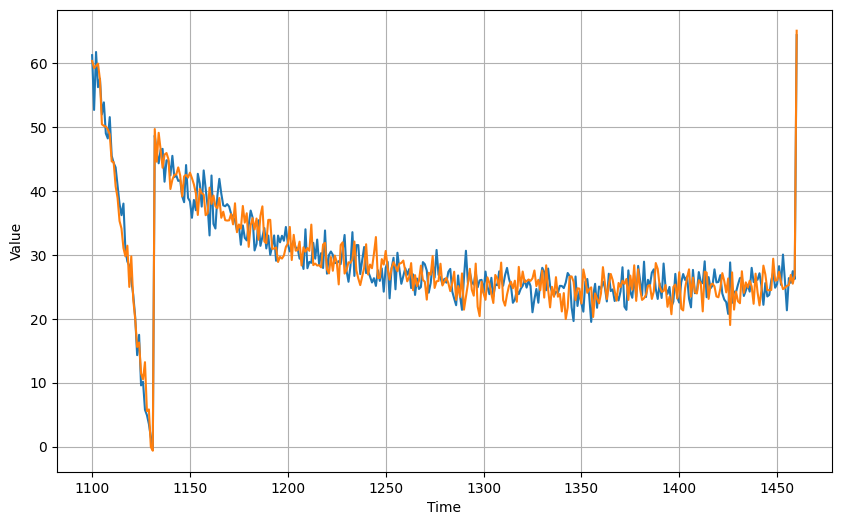

In [244]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, diff_moving_avg_plus_past)

**Expected output:**

<div>
<img src="images/plus_past.png" width="650"/>
</div>

In [245]:
# Compute evaluation metrics
mse, mae = compute_metrics(series_valid, diff_moving_avg_plus_past)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for moving average plus past forecast")

mse: 8.50, mae: 2.33 for moving average plus past forecast


**Expected Output:**

```
mse: 8.50, mae: 2.33 for moving average plus past forecast
```

In [246]:
# Test your code!
unittests.test_diff_moving_avg_plus_past(diff_moving_avg_plus_past)

 All tests passed!


Better than naive forecast, good. However the forecasts look a bit too random, because we're just adding past values, which were noisy. 

### Exercise 8: smooth_past_series

Let's use a moving averaging on **past** values to remove some of the noise. Use a `window_size=10` for this smoothing.

In [267]:
# GRADED VARIABLE
### START CODE HERE ###
# Perform the correct split of SERIES, remember to use a window_size=10
smooth_past_series = moving_average_forecast(SERIES[SPLIT_TIME-370:-359], 11)
### END CODE HERE ###

In [268]:
print(f"smooth past series has shape: {smooth_past_series.shape}\n")

smooth past series has shape: (361,)



In [269]:
# Add the smoothed out past values to the moving avg of diff series
diff_moving_avg_plus_smooth_past = smooth_past_series + diff_moving_avg

print(f"moving average forecast with diff series plus past has shape: {diff_moving_avg_plus_smooth_past.shape}\n")
print(f"comparable with validation series: {series_valid.shape == diff_moving_avg_plus_smooth_past.shape}")

moving average forecast with diff series plus past has shape: (361,)

comparable with validation series: True


**Expected Output:**

```
moving average forecast with diff series plus past has shape: (361,)

comparable with validation series: True
```

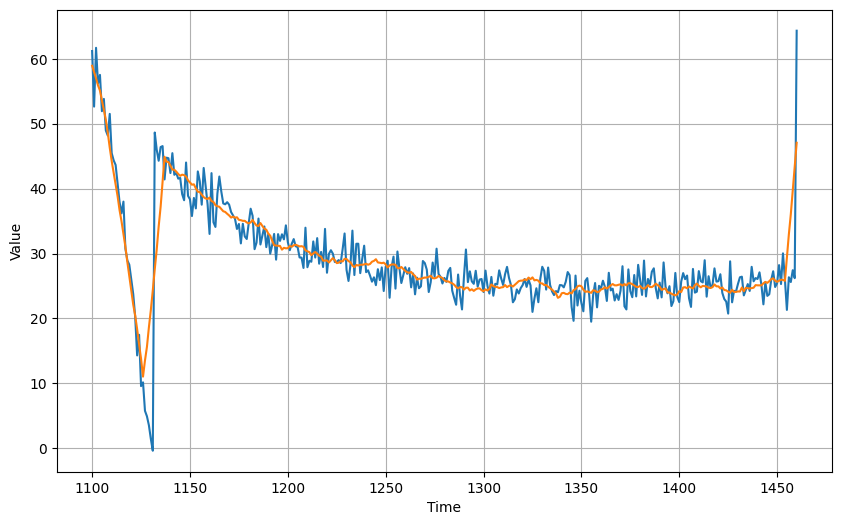

In [270]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, diff_moving_avg_plus_smooth_past)

**Expected output:**

<div>
<img src="images/plus_smooth.png" width="650"/>
</div>

In [271]:
# Compute evaluation metrics
mse, mae = compute_metrics(series_valid, diff_moving_avg_plus_smooth_past)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for moving average plus smooth past forecast")

mse: 13.57, mae: 2.26 for moving average plus smooth past forecast


**Expected Output:**

```
mse: 12.53, mae: 2.20 for moving average plus smooth past forecast
```

In [272]:
# Test your code!
unittests.test_smooth_past_series(smooth_past_series)

 All tests passed!


**Congratulations on finishing this week's assignment!**

You have successfully implemented functions for time series splitting and evaluation while also learning how to deal with time series data and how to code forecasting methods!

**Keep it up!**